In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from FRVRS import nu
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:

# Get tag-to-salt data frame
if nu.pickle_exists('tag_to_salt_df'):
    try:
        tag_to_salt_df = nu.load_object('tag_to_salt_df')
        print(tag_to_salt_df.shape)
        # df = tag_to_salt_df.sample(4).dropna(axis='columns', how='all')
        # display(df.T)
    except AttributeError as e: print(f'Pandas {pd.__version__} get this error: {str(e).strip()}')

Pandas 1.3.2 get this error: Can't get attribute '_unpickle_block' on <module 'pandas._libs.internals' from '/home/dbabbitt/anaconda3/envs/itm_analysis_reporting/lib/python3.7/site-packages/pandas/_libs/internals.cpython-37m-x86_64-linux-gnu.so'>



# Triage Accuracy

(How many patients did they get right and do they do it in the right order, for example: still or obvious life threat first (Red, Gray, Black), then wavers, then walkers last.)


<img src="http://localhost:8889/files/itm-analysis-reporting/saves/png/salt_mass_casualty_triage.png" />


### Correct Count by Tag

In [4]:

tag_to_salt_df.predicted_tag.unique()

array([nan, 'green', 'black', 'gray', 'red', 'yellow'], dtype=object)

In [5]:

# Get the total and correct counts for each run for each tag
rows_list = []
tagged_mask_series = tag_to_salt_df.last_tag.isnull() | tag_to_salt_df.max_salt.isnull()

# Add the normal section
groupby_columns = ['session_uuid', 'scene_id', 'predicted_tag']
for (session_uuid, scene_id, predicted_tag), df in tag_to_salt_df[~tagged_mask_series].groupby(groupby_columns):
    
    # Add the logger version, groupby columns, and scene categories to the row dictionary
    row_dict = {}
    row_dict['logger_version'] = fu.get_logger_version(df)
    for cn in groupby_columns: row_dict[cn] = eval(cn)
    row_dict['is_scene_aborted'] = fu.get_is_scene_aborted(df)
    row_dict['scene_type'] = fu.get_scene_type(df)

    # Add the total and correct counts for this run
    mask_series = (df.is_tag_correct == True)
    correct_count = df[mask_series].patient_count.sum()
    row_dict['correct_count'] = correct_count
    total_count = df.patient_count.sum()
    row_dict['total_count'] = total_count
    
    # Add percentage that tag is correct
    try: percentage_tag_correct = 100*correct_count/total_count
    except Exception: percentage_tag_correct = np.nan
    row_dict['percentage_tag_correct'] = percentage_tag_correct
    
    # Add the row dictionary to the list
    rows_list.append(row_dict)

# Add the not-tagged section
for (session_uuid, scene_id), df in tag_to_salt_df[tagged_mask_series].groupby(fu.scene_groupby_columns):
    
    # Add the logger version, groupby columns, and scene categories to the row dictionary
    row_dict = {}
    row_dict['logger_version'] = fu.get_logger_version(df)
    for cn in fu.scene_groupby_columns: row_dict[cn] = eval(cn)
    row_dict['predicted_tag'] = 'Not Tagged'
    row_dict['is_scene_aborted'] = fu.get_is_scene_aborted(df)
    row_dict['scene_type'] = fu.get_scene_type(df)

    # Add the total and correct counts for this run
    mask_series = (df.is_tag_correct == True)
    correct_count = df[mask_series].patient_count.sum()
    row_dict['correct_count'] = correct_count
    total_count = df.patient_count.sum()
    row_dict['total_count'] = total_count
    
    # Add percentage that tag is correct
    try: percentage_tag_correct = 100*correct_count/total_count
    except Exception: percentage_tag_correct = np.nan
    row_dict['percentage_tag_correct'] = percentage_tag_correct
    
    # Add the row dictionary to the list
    rows_list.append(row_dict)

# Create the correct count data frame
correct_count_by_tag_df = pd.DataFrame(rows_list)

In [6]:

correct_count_by_tag_df

,logger_version,session_uuid,scene_id,predicted_tag,is_scene_aborted,scene_type,correct_count,total_count,percentage_tag_correct
0,1.3,009b848c-ea64-4f22-bd40-711213a3d327,1,green,False,Triage,0,1,0.0
1,1.3,009b848c-ea64-4f22-bd40-711213a3d327,2,black,False,Triage,0,1,0.0
2,1.3,009b848c-ea64-4f22-bd40-711213a3d327,2,gray,False,Triage,1,1,100.0
3,1.3,009b848c-ea64-4f22-bd40-711213a3d327,2,green,False,Triage,2,2,100.0
4,1.3,009b848c-ea64-4f22-bd40-711213a3d327,2,red,False,Triage,3,4,75.0
...,...,...,...,...,...,...,...,...,...
3363,1.3,ff4c3532-5924-45b6-9a6a-d0d3274b6ef0,2,Not Tagged,False,Triage,0,1,0.0
3364,1.0,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,0,Not Tagged,False,Orientation,0,4,0.0
3365,1.0,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,1,Not Tagged,False,Triage,0,8,0.0
3366,1.3,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,0,Not Tagged,False,Orientation,0,4,0.0


In [7]:

mask_series = correct_count_by_tag_df.predicted_tag.isnull()
df = correct_count_by_tag_df[mask_series]
print(df.shape)
display(df.sample(min(5, df.shape[0])).dropna(axis='columns', how='all').T)

(0, 9)


""


,mean,mode,median,SD,min,25%,50%,75%,max
correct_green_tag_count,1.70,1.0,2.0,0.97,0.0,1.00,2.0,3.0,4.0
total_green_tag_count,2.15,3.0,2.0,1.03,1.0,1.00,2.0,3.0,4.0
percentage_green_tag_correct,80.93,100.0,100.0,30.68,0.0,66.67,100.0,100.0,100.0


,mean,mode,median,SD,min,25%,50%,75%,max
correct_black_tag_count,0.97,1.0,1.0,0.17,0.0,1.0,1.0,1.0,1.0
total_black_tag_count,1.00,1.0,1.0,0.00,1.0,1.0,1.0,1.0,1.0
percentage_black_tag_correct,97.09,100.0,100.0,16.83,0.0,100.0,100.0,100.0,100.0


,mean,mode,median,SD,min,25%,50%,75%,max
correct_gray_tag_count,0.70,1.0,1.0,0.46,0.0,0.0,1.0,1.0,1.0
total_gray_tag_count,1.00,1.0,1.0,0.00,1.0,1.0,1.0,1.0,1.0
percentage_gray_tag_correct,70.21,100.0,100.0,45.80,0.0,0.0,100.0,100.0,100.0


,mean,mode,median,SD,min,25%,50%,75%,max
correct_red_tag_count,2.61,2.0,2.0,1.13,0.0,2.0,2.0,4.0,6.0
total_red_tag_count,3.21,4.0,4.0,1.15,1.0,2.0,4.0,4.0,9.0
percentage_red_tag_correct,83.45,100.0,100.0,24.53,0.0,75.0,100.0,100.0,100.0


,mean,mode,median,SD,min,25%,50%,75%,max
correct_yellow_tag_count,1.25,1.0,1.0,0.69,0.0,1.0,1.0,2.0,3.0
total_yellow_tag_count,1.61,2.0,2.0,0.61,1.0,1.0,2.0,2.0,3.0
percentage_yellow_tag_correct,78.85,100.0,100.0,35.36,0.0,50.0,100.0,100.0,100.0


,mean,mode,median,SD,min,25%,50%,75%,max
correct_not_tagged_tag_count,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
total_not_tagged_tag_count,7.43,8.0,8.0,3.28,1.0,8.0,8.0,9.0,25.0
percentage_not_tagged_tag_correct,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


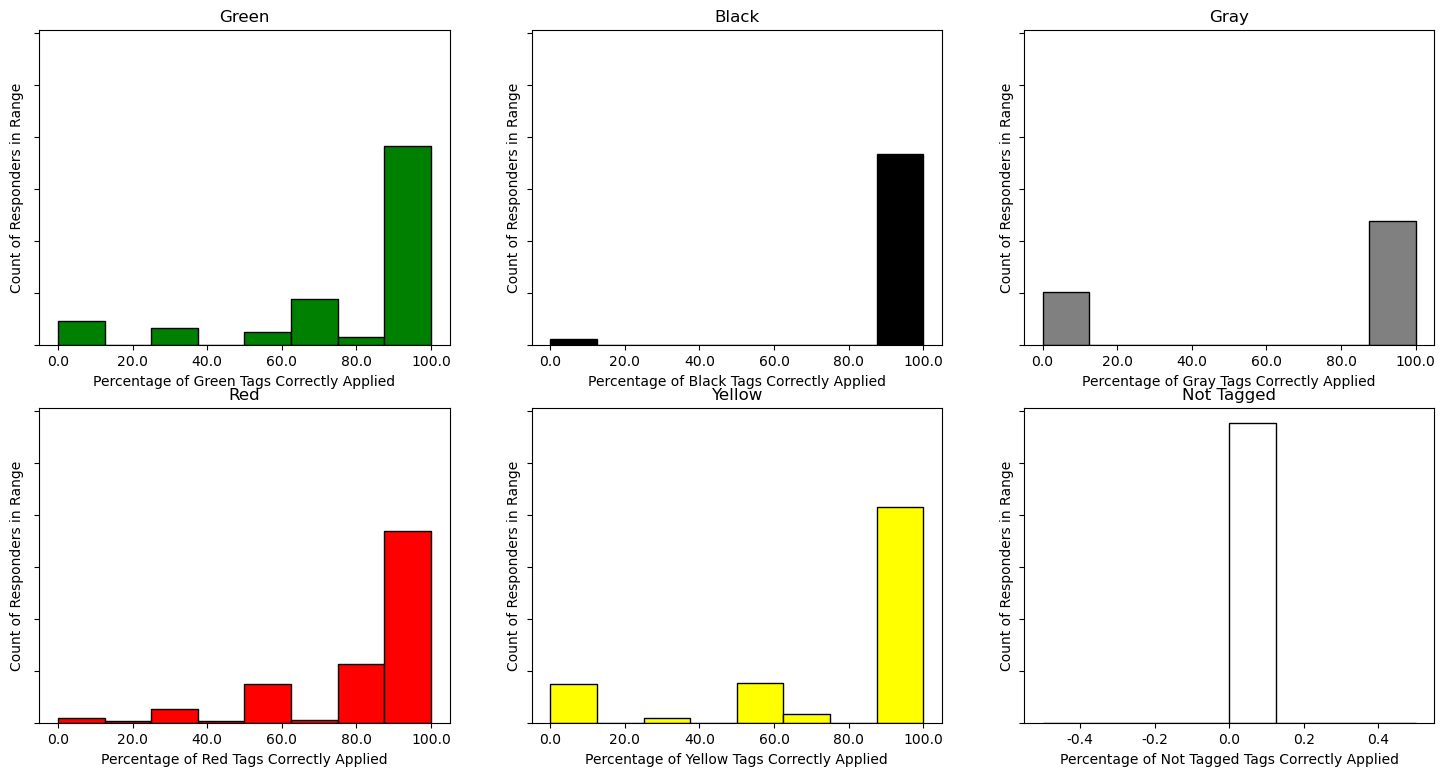

In [9]:

# Display a histogram of the percentage of tags correctly applied based on the patient record SALT, separated by tag
get_xtick_text = lambda text_obj: round(text_obj.get_position()[0], 2)
ylabel = 'Count of Responders in Range'

# Calculate the number of plots and the number of rows and columns
unique_tags = correct_count_by_tag_df.predicted_tag.unique()
num_plots = len(unique_tags)
num_rows = min(num_plots, 2)
num_cols = int(np.ceil(num_plots / num_rows))

# Create a figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 9), sharex=False, sharey=True)
columns_list = [
    'correct_count', 'total_count', 'percentage_tag_correct'
]
for i, predicted_tag in enumerate(unique_tags):
    
    # Get the histogram data
    mask_series = (correct_count_by_tag_df.predicted_tag == predicted_tag)
    mask_series &= (correct_count_by_tag_df.scene_type == 'Triage') & (correct_count_by_tag_df.is_scene_aborted == False)
    xlabel = f'Percentage of {predicted_tag.title()} Tags Correctly Applied'
    color = 'white' if (predicted_tag == 'Not Tagged') else predicted_tag.lower()
    ax = nu.plot_histogram(
        correct_count_by_tag_df[mask_series], 'percentage_tag_correct', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=predicted_tag.title(), ylabel=ylabel,
        xticks_are_temporal=False, ax=axs[i // num_cols, i % num_cols], color=color, bins=8
    )
    
    axs[i // num_cols, i % num_cols].grid(False)
    
    # Can you provide the following statistics for this distribution: mean, median, mode, SD, Interquartile range?
    renamed_columns_list = [
        f'correct_{predicted_tag}_tag_count', f'total_{predicted_tag}_tag_count', f'percentage_{predicted_tag}_tag_correct'
    ]
    renamed_columns_list = [cn.lower().replace(' ', '_') for cn in renamed_columns_list]
    df = correct_count_by_tag_df[mask_series][columns_list].rename(columns={k: v for k, v in zip(columns_list, renamed_columns_list)})
    display(fu.get_statistics(df, renamed_columns_list).applymap(lambda x: round(x, 2), na_action='ignore').T)

# Remove the remainder of the plots
i += 1
while i < (num_rows * num_cols):
    axs[i // num_cols, i % num_cols].remove()
    i += 1

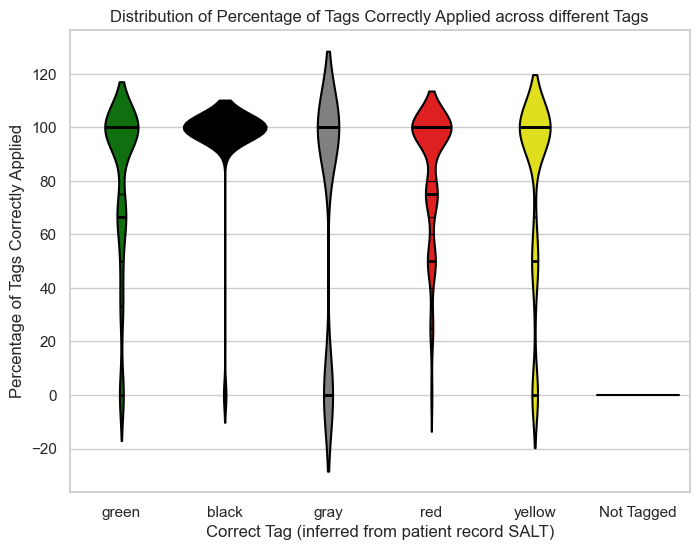

In [27]:

import seaborn as sns

# Sample data for the violin plot
data = {
    'predicted_tag': correct_count_by_tag_df.predicted_tag.tolist(),
    'percentage_tag_correct': correct_count_by_tag_df.percentage_tag_correct.tolist()
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Set the style of the plot
sns.set(style='whitegrid')

# Create the violin plot with 5 violins
plt.figure(figsize=(8, 6))
palette = ['white' if (color == 'Not Tagged') else color for color in unique_tags]
sns.violinplot(x='predicted_tag', y='percentage_tag_correct', data=df, palette=palette, inner='stick')

# Set plot labels and title
plt.xlabel('Correct Tag (inferred from patient record SALT)')
plt.ylabel('Percentage of Tags Correctly Applied')
plt.title('Distribution of Percentage of Tags Correctly Applied across different Tags')

# Show the plot
plt.show()